In [1]:
#####################
## IMPORT WAV FILE ##
#####################
import os
from scipy.io import wavfile

input_path = os.getcwd() + "/data/input.wav"
fs, data = wavfile.read(input_path)  # read audio recording, extract sampling rate and data

total_num_samples = len(data)  # number of samples in recording
total_time = total_num_samples/fs  # total time length of recording

print('sampling rate:', fs)
print('total number of samples:', total_num_samples)
print('total time:', total_time)

sampling rate: 44100
total number of samples: 288704
total time: 6.546575963718821


In [2]:
###########################
## DOWNSAMPLE TO 14.7 Hz ##
###########################
data = data[::3]  # keep every 3rd sample
fs = int(fs/3)  # sampling rate is divided by 3
total_num_samples = len(data)  # get new number of samples
total_time = total_num_samples/fs  # get new time length

print('sampling rate:', fs)
print('total number of samples:', total_num_samples)
print('total time:', total_time)

sampling rate: 14700
total number of samples: 96235
total time: 6.546598639455782


In [3]:
###########################
## CHECK AUDIO RECORDING ##
###########################
from IPython.display import Audio

downsampled_path = os.getcwd() + "/data/downsampled_input.wav"
wavfile.write(downsampled_path, fs, data)  # create new wavfile of downsampled input recording
display("Downsampled Input", Audio(downsampled_path))

'Downsampled Input'

Text(0, 0.5, 'Amplitude')

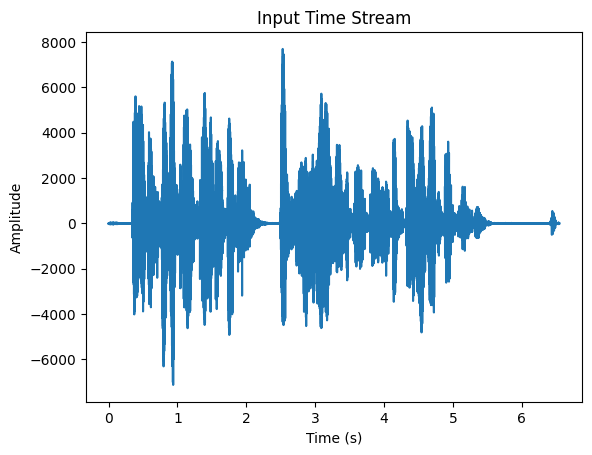

In [4]:
###############################
## PLOT INPUT IN TIME DOMAIN ##
###############################
import numpy as np
import matplotlib.pyplot as plt

time = np.linspace(0, total_time, total_num_samples)  # define a time point for every sample
plt.plot(time, data)
plt.title('Input Time Stream')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

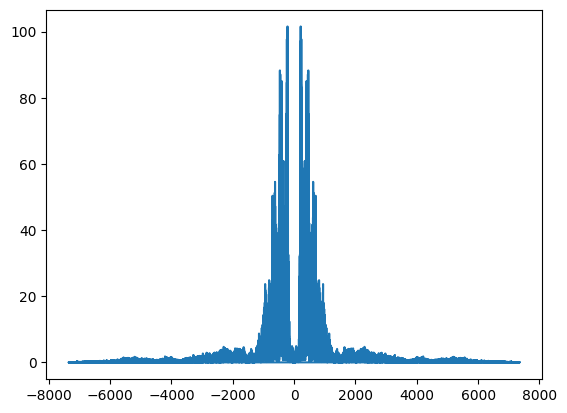

In [5]:
#######################
## PLOT FFT OF INPUT ##
#######################
from scipy.fft import fft, fftfreq

yf = (2/total_num_samples) * np.abs(fft(data))  # note 2/N and absolute
xf = fftfreq(total_num_samples, 1/fs)  # sampling period ts = 1/fs
plt.plot(xf, yf)

In [6]:
#################################
## REORGANIZE DATA INTO CHUNKS ##
#################################

#################################### parameters to change ###################################
num_samples_per_chunk = 550  # corresponds with duration of each chunk
chunk_sample_offset = 440  # number of samples from start of one chunk to start of next chunk
    # chunk_sample_offset = num_samples_per_chunk: consecutive
    # chunk_sample_offset < num_samples_per_chunk: overlapping
    # chunk_sample_offset > num_samples_per_chunl: gaps
#############################################################################################

chunk_time = num_samples_per_chunk/fs  # time length of each chunk
chunk_time_offset = chunk_sample_offset/fs  # time between start of one chunk and start of next chunk

chunks = []  # an n x m array with n chunks and m samples per chunk
current_chunk_start_index = 0  # keep track of where the current chunk is

# create successive chunks until the end of the recording is reached
while current_chunk_start_index + num_samples_per_chunk < total_num_samples:
  this_chunk = data[current_chunk_start_index:current_chunk_start_index+num_samples_per_chunk]  # extract chunk from the data
  chunks.append(this_chunk)  # add to list of chunks
  current_chunk_start_index += chunk_sample_offset  # offset the next chunk

num_chunks = len(chunks)

print('number of chunks:', num_chunks)
print('number of samples per chunk:', num_samples_per_chunk)
print('time of each chunk:', chunk_time)
print('time between start of adjacent chunks:', chunk_time_offset)

number of chunks: 218
number of samples per chunk: 550
time of each chunk: 0.03741496598639456
time between start of adjacent chunks: 0.029931972789115645


In [7]:
######################################
## CREATE ARRAY OF BANDPASS FILTERS ##
######################################
from scipy import signal

#################################### parameters to change ###################################
filter_type = 'butterworth'  # choose from ['butterworth', 'chebyshev', 'elliptic', 'bessel']
order = 3  # order of the filters
min_fc = 100  # smallest centre frequency
max_fc = 7000  # largest centre frequency
bw = 50  # bandwidth
delta_fc = 70  # distance between the centre frequency of each bandpass
   # if delta_fc = bw: consecutive
   # if delta_fc < bw: overlapping
   # if delta_fc > bw: gaps
#############################################################################################

# populate list of centre frequencies
fc_list = []
for fc in range(min_fc, max_fc, delta_fc):
  fc_list.append(fc)

bandpass_filter_array = []  # array to store the filter bank

# create a bandpass filter for each centre frequency in the created list of centre frequencies
for fc in fc_list:
  f1 = fc - bw/2  # lower cutoff frequency
  f2 = fc + bw/2  # higher cutoff frequency

  # create filter of desired type
  if filter_type == 'chebyshev':
    bandpass_filter = signal.cheby1(order, 5, [f1,f2], btype='bandpass', fs=fs, output='sos')
  elif filter_type == 'elliptic':
    bandpass_filter = signal.ellip(order, 5, 40, [f1,f2], btype='bandpass', fs=fs, output='sos')
  elif filter_type == 'bessel':
    bandpass_filter = signal.bessel(order, [f1,f2], btype='bandpass', fs=fs, output='sos')
  else:
    bandpass_filter = signal.butter(order, [f1,f2], btype='bandpass', fs=fs, output='sos')

  # add filter to filter bank
  bandpass_filter_array.append(bandpass_filter)

num_filters = len(bandpass_filter_array)

print('filter type:', filter_type)
print('order:', order)
print('minimum centre frequency (Hz):', min_fc)
print('maximum centre frequency (Hz):', max_fc)
print('bandwidth (Hz):', bw)
print('distance between centre frequencies (Hz):', delta_fc)
print('number of bandpass filters in array:', num_filters)

filter type: butterworth
order: 3
minimum centre frequency (Hz): 100
maximum centre frequency (Hz): 7000
bandwidth (Hz): 50
distance between centre frequencies (Hz): 70
number of bandpass filters in array: 99


In [8]:
###############################################
## APPLY BANDPASS FILTER ARRAY ON EACH CHUNK ##
###############################################
output = []  # array to store output recording data

# loop through each chunk
for i in range(0, num_chunks):
  sine_waves = []  # array to store the synthesized sine waves for this chunk

  # loop through each bandpass filter
  for j in range(0, num_filters):
    bpf_output = signal.sosfilt(bandpass_filter_array[j], chunks[i])  # apply this filter on this chunk
    rms = np.sqrt(np.mean(np.square(bpf_output)))  # calculate rms of the output

    # synthesize sine wave
    # specify time domain to cover from start of this chunk to end of this chunk
    chunk_time_domain = np.linspace(i*chunk_time_offset, i*chunk_time_offset+chunk_time, num_samples_per_chunk)
    sine_wave = rms*np.sin(2*np.pi*fc_list[j]*chunk_time_domain)  # sine wave
    sine_waves.append(sine_wave)  # add wave to list

  # superimpose the synthesized sine waves
  superimposed_wave = sine_waves[0]
  for wave in sine_waves[1:]:
    superimposed_wave += wave

  # concatenate the superimposed wave to the output
  output.extend(list(superimposed_wave))

total_output_num_samples = len(output)  # get number of samples in output
total_output_time = total_output_num_samples/fs  # get time duration of output

print('output number of samples:', total_output_num_samples)
print('total output time:', total_output_time)

output number of samples: 119900
total output time: 8.156462585034014


Text(0, 0.5, 'Amplitude')

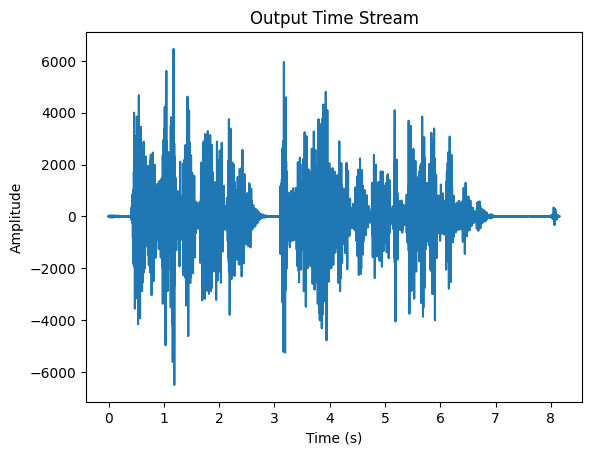

In [9]:
################################
## PLOT OUTPUT IN TIME DOMAIN ##
################################
time = np.linspace(0, total_output_time, total_output_num_samples)  # define a time point for every sample
plt.plot(time, output)
plt.title('Output Time Stream')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

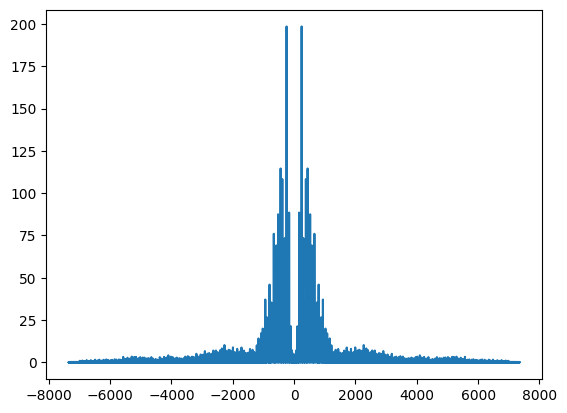

In [10]:
########################
## PLOT FFT OF OUTPUT ##
########################
yf = (2/total_output_num_samples) * np.abs(fft(output))  # note 2/N and the absolute
xf = fftfreq(total_output_num_samples, 1/fs)  # sampling period ts = 1/fs
plt.plot(xf, yf)

In [11]:
############################
## MAP OUTPUT TO WAV FILE ##
############################
output_path = os.getcwd() + "/data/output.wav"
dataout = np.asarray(output, dtype=np.int16)  # convert to numpy array with datatype int16
wavfile.write(output_path, fs, dataout)  # specify same sampling frequency as input

display("Output", Audio(output_path))

'Output'